# Sentinal2Geomedian

**what does this notebook do?** this notebook builds on the **GettingStartedWithSentinel2** notebook; it ueses a loop to load data from sentinal 2 A and B over a set period of time, for a set area and concatinates them together. The data is then cast to float format and used to calculate the geomedian for the selected time range. visible light bands are then plotted at a tre colour image. 

**Tags**
`Sentinel2`, `products`, `GeoMedian`, `threeBandImage`, `dc.load`, `query`, `beginner`, `plot`, `image`,

**Please Note when you start your VDI session you need to module add the `agdc_statistics` module after `dea-prod` to be able to import `datacube_stats`**

In [14]:
% pylab notebook
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import datacube_stats

# Replace '156' and 'cek156' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [15]:
#set up peramiters for data loading

sensors= ['s2a_ard_granule', 's2b_ard_granule'] #pick the sentinal satelites you want

bands_of_int =['red','blue','green'] #pick the sentinal bands that you want, here i am just using visible light  

query = {
        'lat': (-30.755, -30.800),
        'lon': (144.902, 145.000),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2017-01-01', '2018-01-30')
        }
# use s2b_ard_granule 	 for S2B
#data = s2aws.load(product='s2a_ard_granule', group_by='solar_day', **query)

In [17]:
data_sent = {}

for i in sensors:
    this_sensor = s2aws.load(product= i, measurements=bands_of_int, group_by='solar_day', **query)
    
    #retreive projection infromation
    crs = this_sensor.crs
    crswkt = this_sensor.crs.wkt
    affine = this_sensor.affine
    
    #make a mask for full timeseries// if you aren't using a geomedian you may want this, but we don't need it
    #clear_pixels = this_sensor.pixel_quality == 1
    #clear_data = this_sensor.where(clear_pixels)
    
    data_sent[i] = this_sensor

In [18]:
#look at the data 
data_sent

{'s2a_ard_granule': <xarray.Dataset>
 Dimensions:  (time: 35, x: 975, y: 597)
 Coordinates:
   * time     (time) datetime64[ns] 2017-01-01T00:21:02.026000 ...
   * y        (y) float64 -3.41e+06 -3.41e+06 -3.41e+06 -3.41e+06 -3.41e+06 ...
   * x        (x) float64 1.22e+06 1.22e+06 1.22e+06 1.22e+06 1.22e+06 ...
 Data variables:
     red      (time, y, x) int16 7226 7238 7229 7180 7201 7193 7259 7280 7351 ...
     blue     (time, y, x) int16 7043 7121 7122 7176 7214 7234 7249 7178 7188 ...
     green    (time, y, x) int16 7011 7048 7071 7064 7044 7045 7057 7050 7075 ...
 Attributes:
     crs:      EPSG:3577, 's2b_ard_granule': <xarray.Dataset>
 Dimensions:  (time: 19, x: 975, y: 597)
 Coordinates:
   * time     (time) datetime64[ns] 2017-07-08T00:27:09.027000 ...
   * y        (y) float64 -3.41e+06 -3.41e+06 -3.41e+06 -3.41e+06 -3.41e+06 ...
   * x        (x) float64 1.22e+06 1.22e+06 1.22e+06 1.22e+06 1.22e+06 ...
 Data variables:
     red      (time, y, x) int16 1486 1537 1667 1782 1

In [19]:
#concatinate all of the sentinal data together into one xarray, ordered by time 

data_sent = xr.concat(data_sent.values(),'time')
data_sent = data_sent.sortby('time')
data_sent.attrs['crs'] = crs
data_sent.attrs['affin|e'] = affine


In [20]:
data_sent

<xarray.Dataset>
Dimensions:  (time: 54, x: 975, y: 597)
Coordinates:
  * y        (y) float64 -3.41e+06 -3.41e+06 -3.41e+06 -3.41e+06 -3.41e+06 ...
  * x        (x) float64 1.22e+06 1.22e+06 1.22e+06 1.22e+06 1.22e+06 ...
  * time     (time) datetime64[ns] 2017-01-01T00:21:02.026000 ...
Data variables:
    red      (time, y, x) int16 7226 7238 7229 7180 7201 7193 7259 7280 7351 ...
    blue     (time, y, x) int16 7043 7121 7122 7176 7214 7234 7249 7178 7188 ...
    green    (time, y, x) int16 7011 7048 7071 7064 7044 7045 7057 7050 7075 ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 10.00, 0.00, 1219810.00|\n| 0.00,-10.00,-3409600.00|\n| 0.00,...

In [21]:
#cast the data to float numbers so geomedian calculation will work
data_sent_flt = data_sent.astype(float,casting='safe')

In [22]:
#have a look at the data, you can see it's now in float format
data_sent_flt 

<xarray.Dataset>
Dimensions:  (time: 54, x: 975, y: 597)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01T00:21:02.026000 ...
  * y        (y) float64 -3.41e+06 -3.41e+06 -3.41e+06 -3.41e+06 -3.41e+06 ...
  * x        (x) float64 1.22e+06 1.22e+06 1.22e+06 1.22e+06 1.22e+06 ...
Data variables:
    red      (time, y, x) float64 7.226e+03 7.238e+03 7.229e+03 7.18e+03 ...
    blue     (time, y, x) float64 7.043e+03 7.121e+03 7.122e+03 7.176e+03 ...
    green    (time, y, x) float64 7.011e+03 7.048e+03 7.071e+03 7.064e+03 ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 10.00, 0.00, 1219810.00|\n| 0.00,-10.00,-3409600.00|\n| 0.00,...

In [24]:
#create geomedian for data
Sentinal_gm=GeoMedian().compute(data_sent_flt)

In [25]:
#have a look at the geomedian data
Sentinal_gm

<xarray.Dataset>
Dimensions:  (x: 975, y: 597)
Coordinates:
  * y        (y) float64 -3.41e+06 -3.41e+06 -3.41e+06 -3.41e+06 -3.41e+06 ...
  * x        (x) float64 1.22e+06 1.22e+06 1.22e+06 1.22e+06 1.22e+06 ...
Data variables:
    red      (y, x) float64 1.625e+03 1.662e+03 1.709e+03 1.801e+03 ...
    blue     (y, x) float64 782.3 808.6 832.4 841.3 795.2 784.8 833.5 817.2 ...
    green    (y, x) float64 1.085e+03 1.112e+03 1.15e+03 1.187e+03 1.111e+03 ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 10.00, 0.00, 1219810.00|\n| 0.00,-10.00,-3409600.00|\n| 0.00,...

In [26]:
#Prepare geomedian imagery for plotting

rgb = Sentinal_gm.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

<IPython.core.display.Javascript object>


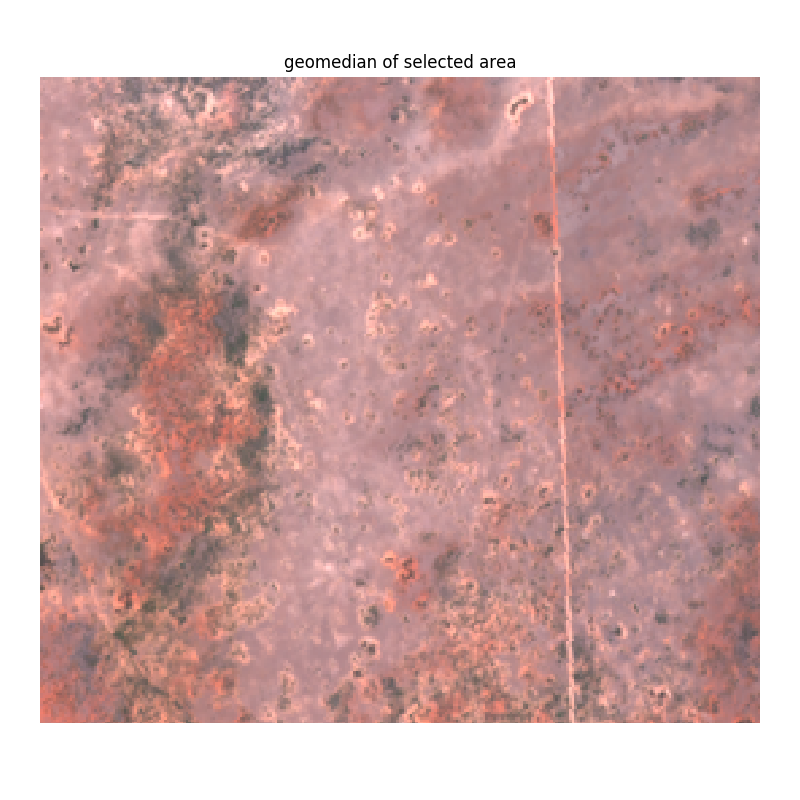

In [27]:
fig = plt.figure(figsize =(8,8)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('geomedian of selected area') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image